In [1]:
import networkx as nx
import igraph as ig
from igraph import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, spearmanr
import scipy.stats as stats
import statistics
import seaborn as sns

import os
import sys

# **Generate the Paper Citation Network**

In [2]:
citation_paper_df = pd.read_csv("data/psoriasis/citation_paper_df.csv")
citation_paper_edge_df = pd.read_csv("data/psoriasis/citation_paper_edge_df.csv")
citation_paper_df.head()

,PMID,author_id,FAU-Revised,DP,title,authors,journal,is_research_article,last_modified,n_ref,...,citations_per_year,expected_citations_per_year,apt,field_citation_rate,rcr,doi,nih_percentile,human,animal,molecular_cellular
0,1280069,"[15264, 22485]","['Kawashima, Makoto', 'Nogita, T']",1992,Increased levels of plasma vitronectin in seve...,"T Nogita, M Kawashima",Arch Dermatol Res,Yes,"04/27/2025, 05:59:08",12,...,0.121212,0.976159,0.05,4.683341,0.12,10.1007/BF00372589,6.0,1.00,0.0,0.00
1,1280904,"[16723, 15764, 12364, 30153]","['Kuki, K', 'Kimura, T', 'Hayashi, Yasuhiro', ...",1992,Focus tonsils and skin diseases with special r...,"K Kuki, T Kimura, Y Hayashi, T Tabata",Adv Otorhinolaryngol,Yes,"04/27/2025, 05:59:10",0,...,0.181818,0.596036,0.05,2.404700,0.31,10.1159/000421744,16.1,1.00,0.0,0.00
2,1281074,"[13458, 11116]","['Husby, G', 'Gran, Jan Tore']",1992,Ankylosing spondylitis. Current drug treatment.,"J T Gran, G Husby",Drugs,Yes,"04/27/2025, 05:59:10",124,...,0.454545,0.696589,0.25,3.007464,0.65,10.2165/00003495-199244040-00006,35.1,0.00,1.0,0.00
3,1284104,"[9611, 11967]","['Fransson, J', 'Hammar, H']",1992,Epidermal growth in the skin equivalent.,"J Fransson, H Hammar",Arch Dermatol Res,Yes,"04/27/2025, 05:59:17",24,...,0.545455,0.695516,0.25,3.001032,0.78,10.1007/BF00372037,41.4,0.57,0.0,0.43
4,1284133,"[24773, 18570, 26415, 4832, 19070, 27004, 3347...","['Portioli, I', 'Lodi, L', 'Rossi, F', 'Casade...",1992,Immunologic effects in patients with psoriatic...,"L Boiardi, C Salvarani, P Macchioni, M Casadei...",J Rheumatol,Yes,"04/27/2025, 05:59:17",29,...,0.272727,0.674121,0.25,2.872779,0.40,NaN,21.8,0.20,0.0,0.80


In [3]:
# node level metadata
node_pmids = list(citation_paper_df['PMID'])
node_DPs = list(citation_paper_df['DP'])
node_titles = list(citation_paper_df['title'])
node_journals = list(citation_paper_df['journal'])
node_authors = citation_paper_df['FAU-Revised'].values
node_author_ids = list(citation_paper_df['author_id'])
node_is_research_article = list(citation_paper_df['is_research_article'])
node_last_modified = list(citation_paper_df['last_modified'])
node_n_refs = list(citation_paper_df['n_ref'])
node_n_cited_by = list(citation_paper_df['n_cited_by'])
node_citations_per_year = list(citation_paper_df['citations_per_year'])
node_expected_citations_per_year = list(citation_paper_df['expected_citations_per_year'])
node_apt = list(citation_paper_df['apt'])
node_field_citation_rate = list(citation_paper_df['field_citation_rate'])
node_rcr = list(citation_paper_df['rcr'])
node_doi = list(citation_paper_df['doi'])
node_nih_percentile = list(citation_paper_df['nih_percentile'])
node_human = list(citation_paper_df['human'])
node_animal = list(citation_paper_df['animal'])
node_molecular_cellular = list(citation_paper_df['molecular_cellular'])

# edge information
citation_paper_edges = list(citation_paper_edge_df[['citing', 'cited']].itertuples(index=False, name=None))

In [4]:
all_pmids = set(citation_paper_edge_df['cited']) | set(citation_paper_edge_df['citing'])
all_pmids = list(all_pmids)
pmid_to_node_id = {pmid: idx for idx, pmid in enumerate(all_pmids)}
edges = [(pmid_to_node_id[citing], pmid_to_node_id[cited]) for citing, cited in citation_paper_edges]

# create the graph
g = Graph(directed=True)
g.add_vertices(len(all_pmids))
g.add_edges(edges)

# assign names and pmids
metadata_df = citation_paper_df.set_index('PMID')
g.vs['name'] = all_pmids

def get_metadata(pmid, col, default=None):
    try:
        return metadata_df.at[pmid, col]
    except KeyError:
        return default

# set all metadata
g.vs['DP'] = [get_metadata(pmid, 'DP') for pmid in all_pmids]
g.vs['title'] = [get_metadata(pmid, 'title') for pmid in all_pmids]
g.vs['journal'] = [get_metadata(pmid, 'journal') for pmid in all_pmids]
g.vs['authors'] = [get_metadata(pmid, 'FAU-Revised') for pmid in all_pmids]
g.vs['author_id'] = [get_metadata(pmid, 'author_id') for pmid in all_pmids]
g.vs['is_research_article'] = [get_metadata(pmid, 'is_research_article') for pmid in all_pmids]
g.vs['last_modified'] = [get_metadata(pmid, 'last_modified') for pmid in all_pmids]
g.vs['n_ref'] = [get_metadata(pmid, 'n_ref') for pmid in all_pmids]
g.vs['n_cited_by'] = [get_metadata(pmid, 'n_cited_by') for pmid in all_pmids]
g.vs['citations_per_year'] = [get_metadata(pmid, 'citations_per_year') for pmid in all_pmids]
g.vs['expected_citations_per_year'] = [get_metadata(pmid, 'expected_citations_per_year') for pmid in all_pmids]
g.vs['apt'] = [get_metadata(pmid, 'apt') for pmid in all_pmids]
g.vs['field_citation_rate'] = [get_metadata(pmid, 'field_citation_rate') for pmid in all_pmids]
g.vs['rcr'] = [get_metadata(pmid, 'rcr') for pmid in all_pmids]
g.vs['doi'] = [get_metadata(pmid, 'doi') for pmid in all_pmids]
g.vs['nih_percentile'] = [get_metadata(pmid, 'nih_percentile') for pmid in all_pmids]
g.vs['human'] = [get_metadata(pmid, 'human') for pmid in all_pmids]
g.vs['animal'] = [get_metadata(pmid, 'animal') for pmid in all_pmids]
g.vs['molecular_cellular'] = [get_metadata(pmid, 'molecular_cellular') for pmid in all_pmids]

In [5]:
print(f"Number of nodes: {len(g.vs)}")
print(f"Number of edges: {len(g.es)}")

Number of nodes: 208632
Number of edges: 621717


# **Compute Pagerank Centrality**

Publications with top Pagerank centrality scores:

In [6]:
pagerank = g.pagerank()
top_n = 10
# https://stackoverflow.com/questions/16486252/is-it-possible-to-use-argsort-in-descending-order
top_indices = np.argsort(-np.array(pagerank))[:top_n]

for i in top_indices:
    pmid = g.vs[i]['name']
    title = g.vs[i]['title']
    is_research_article = g.vs[i]['is_research_article']
    in_deg = g.degree(i, mode='IN')
    out_deg = g.degree(i, mode='OUT')
    journal = g.vs[i]['journal']
    authors = g.vs[i]['authors']
    citations_yearly = g.vs[i]['citations_per_year']
    expected_citations_yearly = g.vs[i]['expected_citations_per_year']
    apt = g.vs[i]['apt']
    fcr = g.vs[i]['field_citation_rate']
    rcr = g.vs[i]['rcr']
    nih_percentile = g.vs[i]['nih_percentile']

    print(f"PMID: {pmid}, PageRank: {pagerank[i]:.5f}, In-degree: {in_deg}, Out-degree: {out_deg}\n"
          f"\tTitle: {title}\n"
          f"\tJournal: {journal}, Article: {is_research_article}\n"
          f"\tCitations yearly: {citations_yearly:.5f}\n"
          f"\tExp. citations yearly: {expected_citations_yearly:.5f}\n"
          f"\tAPT: {apt:.5f}\n"
          f"\tField citation rate: {fcr:.5f}\n"
          f"\tRCR: {rcr:.5f}\n"
          f"\tNIH percentile: {nih_percentile:.5f}\n"
          f"\tAuthors: {', '.join(authors) if isinstance(authors, list) else authors}\n")

PMID: 1536755, PageRank: 0.00810, In-degree: 166, Out-degree: 0
	Title: The immunology of psoriasis.
	Journal: Br J Dermatol, Article: No
	Citations yearly: 5.03030
	Exp. citations yearly: 1.01764
	APT: 0.75000
	Field citation rate: 4.93198
	RCR: 4.94000
	NIH percentile: 92.90000
	Authors: ['Fry, Lionel', 'Baker, Barbara S']

PMID: 7584949, PageRank: 0.00771, In-degree: 6549, Out-degree: 1
	Title: Angiogenesis in cancer, vascular, rheumatoid and other disease.
	Journal: Nat Med, Article: No
	Citations yearly: 218.30000
	Exp. citations yearly: 1.29362
	APT: 0.95000
	Field citation rate: 5.61545
	RCR: 168.75000
	NIH percentile: 100.00000
	Authors: ['Folkman, J']

PMID: 7512793, PageRank: 0.00740, In-degree: 169, Out-degree: 0
	Title: Aberrant production of interleukin-8 and thrombospondin-1 by psoriatic keratinocytes mediates angiogenesis.
	Journal: Am J Pathol, Article: Yes
	Citations yearly: 5.45161
	Exp. citations yearly: 1.22943
	APT: 0.75000
	Field citation rate: 5.65929
	RCR: 4.430

# **Correlation of Pagerank Centrality and Paper Metrics**

In [7]:
graph_pmids = set(g.vs['name'])
# https://interactivechaos.com/en/python/function/pandasdataframeselectdtypes#:~:text=The%20method%20select_dtypes%20of%20pandas,category%22%20%2C%20for%20example).
metrics = citation_paper_df.select_dtypes(include=['number']).columns.to_list()

katz_correlations = {}
for metric in metrics:
    # filter for pmids in the graph and make sure the metric exists for that entry (no nans to correlation)
    # also I exclude specific PMID due to icite error on that PMID alone
    valid_rows = citation_paper_df[
        citation_paper_df['PMID'].isin(graph_pmids) &
        ~citation_paper_df[metric].isna() &
        (citation_paper_df['PMID'] != 1345156)]
    
    # Find valid indices for which pmid exists for map
    pmid_to_index = {name: idx for idx, name in enumerate(g.vs['name'])}
    node_indices = valid_rows['PMID'].map(pmid_to_index).values
    
    # subset to data we need from valid rows and subset valid indices for pagerank
    nih_percentiles = valid_rows[metric].values
    pagerank_array = np.array(pagerank)
    pagerank_subset = pagerank_array[node_indices]
    
    # Non-parametric correlation test
    rho, p = spearmanr(nih_percentiles, pagerank_subset)
    
    print(f"Spearman's rank correlation for {metric} vs Pagerank centrality: {rho}")
    print(f"p value: {p}")

    katz_correlations[metric] = {'rho': rho, 'p': p}

Spearman's rank correlation for PMID vs Pagerank centrality: -0.28047912748377246
p value: 9.547442434483448e-274
Spearman's rank correlation for DP vs Pagerank centrality: -0.2703001610251833
p value: 1.228786939507924e-253
Spearman's rank correlation for n_ref vs Pagerank centrality: 0.4273825061747578
p value: 0.0
Spearman's rank correlation for n_cited_by vs Pagerank centrality: 0.852794565466899
p value: 0.0
Spearman's rank correlation for citations_per_year vs Pagerank centrality: 0.764917882236146
p value: 0.0
Spearman's rank correlation for expected_citations_per_year vs Pagerank centrality: 0.1263753533553524
p value: 3.7328760664108994e-55
Spearman's rank correlation for apt vs Pagerank centrality: 0.6237924963681398
p value: 0.0
Spearman's rank correlation for field_citation_rate vs Pagerank centrality: 0.36372548510590835
p value: 0.0
Spearman's rank correlation for rcr vs Pagerank centrality: 0.8142062733896173
p value: 0.0
Spearman's rank correlation for nih_percentile vs

DP (Date Published) and PMID (by proxy of PMID orderings from oldest to newest) are negatively correlated with pagerank centrality, as these are more recent papers that have not had as long of a chance to be cited yet - thus less influential. This is speculation, but papers published on human subjects are probably negatively correlated as they are generally patient case or cohort studies that don't reveal much about about underlying disease mechanisms of psoriasis. Additionally, these studies are limited in what kinds of treatments can be applied in human subjects, thus leaving less of an "impact". Number of references that a paper lists might be positively correlated, simply based on the fact that longer papers tend to likely have more references. Whereas, shorter papers may not generate as interesting of new insights on psoriasis, probably sticking to summarizing other results. Evidently, NIH percentile, relative citation ratio, number of citations, and citations per year are very postively correlated with pagerank centrality, as they are in part determined by edge structures inherent in the network. APT - the approximate potential to translate into the clinical space, is also positively correlated - probably less so than others like RCR, as highly central papers may also be summaries and have no direct ability to translate. 

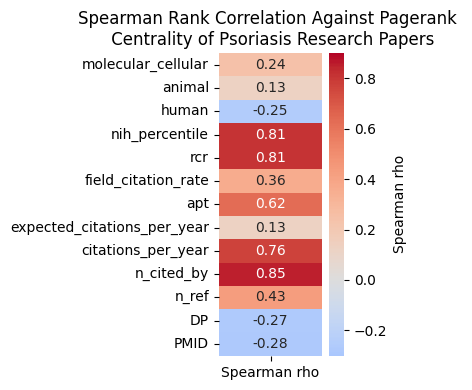

In [8]:
labels = citation_paper_df.select_dtypes(include=['number']).columns.to_list()
rhos = [item['rho'] for item in katz_correlations.values()]
ps = [item['p'] for item in katz_correlations.values()]

# Create DataFrame for the heatmap
uniform_data = pd.DataFrame([rhos], columns=labels)
vmin, vmax = -0.3, 0.90

# https://seaborn.pydata.org/generated/seaborn.heatmap.html
# https://stackoverflow.com/questions/54506626/how-to-understand-seaborns-heatmap-annotation-format
# https://stackoverflow.com/questions/63892337/how-to-rotate-seaborn-heatmap-in-python
# https://stackoverflow.com/questions/42092218/how-to-add-a-label-to-seaborn-heatmap-color-bar
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(uniform_data.T, annot=True, cmap='coolwarm', fmt=".2f", center=0, cbar_kws={"label": "Spearman rho"}, ax=ax, vmin=vmin, vmax=vmax)
ax.invert_yaxis()
plt.title("Spearman Rank Correlation Against Pagerank \n Centrality of Psoriasis Research Papers")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.xlabel("Spearman rho")

# https://stackoverflow.com/questions/12998430/how-to-remove-xticks-from-a-plot
plt.setp(ax.get_xticklabels(), visible=False)
plt.tight_layout()
plt.show()

# **Citation/Collaboration Insularity: Do Authors Cite Themselves and their Collaborators? How so?**

## Generate the Author Collaboration Network 1992 and After

In [78]:
raw_df = pd.read_excel("data/psoriasis/psoriasis.xlsx", sheet_name='Dataset')
collab_author_df = pd.read_csv("data/psoriasis/author_df.csv")
collab_edge_df = pd.read_csv("data/psoriasis/edge_df.csv")

In [60]:
# filter for author ids 1992, reindex and remap edges, and after and then apply that to the edge list
pmids_after_1992 = raw_df[raw_df['DP'] >= 1992]['PMID'].tolist()
collab_edge_df = collab_edge_df[collab_edge_df['source'].isin(ids_after_1992) & collab_edge_df['target'].isin(ids_after_1992)]
collab_author_df = collab_author_df[collab_author_df['author_id'].isin(ids_after_1992)].reset_index()

# Mapping of author_d
author_id_to_index = dict(zip(collab_author_df['author_id'], collab_author_df.index))

# Remap source and target using the mapping
collab_edge_df['source'] = collab_edge_df['source'].map(author_id_to_index)
collab_edge_df['target'] = collab_edge_df['target'].map(author_id_to_index)

# generate list and tuples for author nodes and edges (citations)
collab_author_edges = list(collab_edge_df[['source', 'target']].itertuples(index=False, name=None))
collab_author_verts = list(collab_author_df.index)
collab_author_names = list(collab_author_df['FAU-Revised'])

In [61]:
collab_g = Graph()
collab_g.add_vertices(len(collab_author_verts))
collab_g.add_edges(collab_author_edges)
collab_g.vs['names'] = collab_author_names

In [81]:
collab_edge_df

,source,source_name,target,target_name
0,16252,"Gönlüşen, G",44038,"Uzun, Soner"
1,6327,"Caloto, Ma Teresa",36473,"Roset, Montse"
2,25709,"Long, Li",45496,"Wang, Shi-Yao"
3,7197,"Chan, Ting-Fung",46909,"Xiao, Ming"
4,4388,"Blanco, Francisco Javier",14647,"Giardina, Emiliano"
...,...,...,...,...
211535,32977,"Paul, Carle F",44575,"Verboom, P"
211536,34372,"Prens, Errol P",46531,"Wohn, Christian"
211537,6225,"Cafaro, Giovanni",10182,"Di Minno, Matteo Nicola Dario"
211538,34558,"Puapairoj, Chintana",36333,"Romphruk, Arunrat"


In [69]:
collab_author_df

,index,FAU-Revised,author_id,total_pubs,total_citations,avg_nih_percentile,avg_relative_citation_ratio,avg_citations,n_collaborations,affiliation,n_first_author,n_last_author,n_single_author,n_missing_author
0,32828,"Parrish-Novak, J",32828,1,447,96.80,8.00,447.00,25,NaN,NaN,NaN,NaN,NaN
1,32829,"Parrochi, P",32829,1,11,15.10,0.29,11.00,8,NaN,NaN,NaN,NaN,NaN
2,32830,"Parronchi, Paola",32830,2,603,68.30,5.90,301.50,25,NaN,NaN,NaN,NaN,NaN
3,32831,"Parsa, Ramine",32831,1,16,14.30,0.27,16.00,4,NaN,NaN,NaN,NaN,NaN
4,32832,"Parsad, D",32832,1,14,16.50,0.31,14.00,3,NaN,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16131,48959,"Ćalasan, Maja Bulatović",48959,1,60,81.60,2.59,60.00,6,NaN,1.0,0.0,0.0,0.0
16132,48960,"Şenyurt, Süleyman Ziya",48960,1,22,48.40,0.95,22.00,8,NaN,NaN,NaN,NaN,NaN
16133,48961,"Šipek-Dolnicar, Alenka",48961,1,47,70.50,1.76,47.00,6,NaN,NaN,NaN,NaN,NaN
16134,48962,"Štolfa, Jiří",48962,4,71,28.38,0.64,17.75,16,NaN,1.0,0.0,0.0,0.0


## Generate the Author Citation Network

In [24]:
citation_author_df = pd.read_csv("data/psoriasis/author_df.csv")
raw_df = pd.read_excel("data/psoriasis/psoriasis.xlsx", sheet_name='Dataset')
pmids = raw_df["PMID"].unique().tolist()

In [46]:
# filter for paper edges in which pmids are known to have metadata
known_paper_collaborations = citation_paper_edge_df[citation_paper_edge_df['cited'].isin(pmids) & citation_paper_edge_df['citing'].isin(pmids)]

,PMID,DP,FAU,FAU-Revised
0,18913797,1942,"COMEL, M, M","COMEL, M"
1,20981993,1945,"DEGOS, R, R","Degos, R"
2,21020988,1945,GOMEZ ORBANEJA,"Gómez Orbaneja, J"
3,21020988,1945,GARCIA PEREZ,GARCIA PEREZ
4,20983377,1945,"NIEMEYER, A, A","NIEMEYER, A"
...,...,...,...,...
109275,23266843,2013,"Augustin, Matthias, M","Augustin, Matthias"
109276,23266843,2013,"Rustenbach, Stephan J, SJ","Rustenbach, Stephan J"
109277,23266843,2013,"Beikert, Florian C, FC","Beikert, Florian C"
109278,23558018,2013,"Mattila, Kalle, K","Mattila, Kalle"
